### Anomaly Detection 

* You have m = 307 unlabelled samples of how the servers are performing
* The dataset contains two features -- throughput (mb/s) and lactency of response (ms)
* Most examples are normal but a few servers are acting anomalously within the dataset
* You will first start on a 2D dataset that can be visualized

(307, 2) (307, 2) (307,)


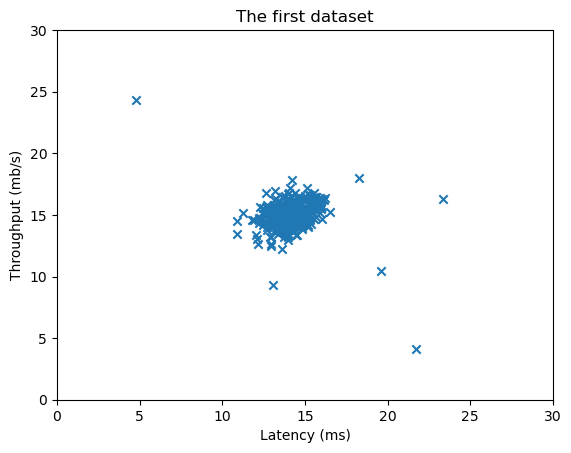

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def load_data():
    X = np.load("data/X_part1.npy")
    X_val = np.load("data/X_val_part1.npy")
    y_val = np.load("data/y_val_part1.npy")
    return X, X_val, y_val

# X train is used to fit a Gaussian distribution
# X val and y val are used for cross validation set to select a threshold

X_train, X_val, y_val = load_data()

print(X_train.shape, X_val.shape, y_val.shape)

# Plot a scatter plot using each feature for the axis
plt.scatter(X_train[:, 0], X_train[:, 1], marker='x')
plt.title("The first dataset")
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")
plt.axis([0, 30, 0, 30])
plt.show()

In [3]:
def estimate_gaussian(X):
    m, n = X.shape

    '''
    mu, var = np.zeros(n), np.zeros(n)
    for i in range(n):
        mu[i] = np.mean(X[:, i], axis=0)
        var[i] = np.var(X[:, i], axis=0)
    '''

    mu = 1/m * np.sum(X, axis = 0)
    var = 1/m * np.sum((X - mu) ** 2, axis = 0)
    
    return mu, var

mu, var = estimate_gaussian(X_train)
print(mu, var)

[14.11222578 14.99771051] [1.83263141 1.70974533]


#### Multivariate Gaussian Distribution

This is of the utmost importance to understand what exactly is going on with the linear algebra here. It is just the vectorized implementation of the probability calculation in our notes!

In [6]:
def multivariate_gaussian(X, mu, var):

    """
    Computes the probability 
    density function of the examples X under the multivariate gaussian 
    distribution with parameters mu and var. If var is a matrix, it is
    treated as the covariance matrix. If var is a vector, it is treated
    as the var values of the variances in each dimension (a diagonal
    covariance matrix
    """

    k = len(mu)
    
    if var.ndim == 1:
        var = np.diag(var)
    
    X = X - mu

    # This is the vectorized version of the multivariate gaussian distribution
    # In the notes it is given as the product of probabilities of each feature...
    p = (2 * np.pi) ** (-k/2) * np.linalg.det(var)**(-0.5) * \
        np.exp(-0.5 * np.sum(np.matmul(X, np.linalg.pinv(var)) * X, axis = 1))
    
    return p

In [9]:
def select_threshold(y_val, p_val):
    '''
    Finds the best threshold to use for selecting outliers 
    based on the results from a validation set (p_val) 
    and the ground truth (y_val) using the F1 score.
    '''
    best_epsilon = 0
    best_f1 = 0
    f1 = 0
    step_size = (max(p_val) - min(p_val)) / 1000

    for epsilon in np.arange(min(p_val), max(p_val), step_size):
        predictions = (p_val < epsilon)
        # if you have several binary values in an nd binary vector, 
        # you can find how many of them are 0 by doing np.sum(v == 0)
        tp = np.sum((predictions == 1) & (y_val == 1)) # true positives
        fp = np.sum((predictions == 1) & (y_val == 0)) # false positives
        fn = np.sum((predictions == 0) & (y_val == 1)) # false negatives
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        f1 = 2 * prec * rec / (prec + rec)

        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
    
    return best_epsilon, best_f1

p_val = multivariate_gaussian(X_val, mu, var)
epsilon, f1 = select_threshold(y_val, p_val)
print(epsilon, f1)

8.990852779269495e-05 0.8750000000000001


/var/folders/qg/563v30d5119bt_zbv8qgbst80000gn/T/ipykernel_15783/2788454878.py:19: RuntimeWarning: invalid value encountered in scalar divide
  prec = tp / (tp + fp)


In [13]:
p = multivariate_gaussian(X_train, mu, var)
outliers = np.where(p < epsilon)
print(outliers)

(array([300, 301, 303, 304, 305, 306]),)


#### High Dimensional Dataset

In [14]:
def load_data_multi():
    X = np.load("data/X_part2.npy")
    X_val = np.load("data/X_val_part2.npy")
    y_val = np.load("data/y_val_part2.npy")
    return X, X_val, y_val

X_train_high, X_val_high, y_val_high = load_data_multi()

print(X_train_high.shape, X_val_high.shape, y_val_high.shape)

(1000, 11) (100, 11) (100,)


We will follow the same procedure:
* Estimate Gaussian parameters (mu and var for each feature)
* Evaluate probabilities for training data from the estimated parameters, as well as for CV set
* Use select threshold to find best threshold epsilon

In [15]:
mu_high, var_high = estimate_gaussian(X_train_high)
p_high = multivariate_gaussian(X_train_high, mu_high, var_high)
p_val_high = multivariate_gaussian(X_val_high, mu_high, var_high)
epsilon_high, f1_high = select_threshold(y_val_high, p_val_high)
print(epsilon_high, f1_high)
print("# of outliers: %d" % np.sum(p_high < epsilon_high))

1.377228890761358e-18 0.6153846153846154
# of outliers: 117


/var/folders/qg/563v30d5119bt_zbv8qgbst80000gn/T/ipykernel_15783/2788454878.py:19: RuntimeWarning: invalid value encountered in scalar divide
  prec = tp / (tp + fp)
